# Run a variational algorithm with Amazon Braket Hybrid Jobs

This tutorial shows how to run your first algorithm on Amazon Braket Hybrid Jobs. 

Most potential candidates for quantum applications don't just run on a QPU. Instead, the workload likely shifts back and forth between a CPU/GPU and a QPU. Let's work with a very simple problem to illustrate this:

To get started, we consider the example of a one-qubit circuit with an $RX(\theta)$ gate and we measure the expectation value of the $Z$ operator.

<div align="center">
    <img src="circuit.png" width="400" />
</div>

<div class="alert alert-block alert-info">
<b>
    Let us pose the problem of finding the value of $\theta$ that minimizes the expectation value $\langle Z\rangle$ and solve using a variational quantum-classical approach.
</b>
</div>

<div align="center">
<img src="variational_algorithm.png" width="600"/>
</div>

<br>

In this hands-on lab, you will learn how you can
* Write an algorithm to run on Braket Hybrid Jobs
* Work with PennyLane on Amazon Braket
* Create a job on Braket simulators or QPUs
* Monitor the job state
* Retrieve job results

Let us begin by importing some modules we need in this notebook.

In [1]:
from braket.jobs.metrics import log_metric
from braket.jobs import hybrid_job
from braket.jobs.environment_variables import get_job_device_arn
from braket.tracking import Tracker
from braket.devices import Devices
from braket.aws import AwsDevice, AwsQuantumJob

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML

from utils import bloch_sphere_animation, plot_job_metrics

%matplotlib inline

Before we review the notebook, let us already start a job on a real QPU now.

**Note:** The following cell creates tasks on a real QPU which will cost about $100.

In [2]:
import demo_job

# job_iqm = demo_job.create()
# print(job_iqm.arn, job_iqm.state())

## Toy Problem

Let us review our hello-world problem introduced above.

<div align="center">
    <img src="circuit.png" width="400" />
</div>

<div class="alert alert-block alert-info">
    <b>What value of the angle $\theta$ applied to a single-qubit $X$ rotation minimizes the expectation value $\langle Z\rangle$?<b>
</div>

Obviously, this problem can be solved analytically, straightforward. 

With $$\left|0\right> = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$ and $$R_x(\theta) = \begin{pmatrix} \cos{\frac{\theta}{2}} & -i \sin{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix}$$ the quantum state $\left|\psi\right>$ prepared by the circuit above results in $$ \left|\psi\right> = R_x(\theta) \left|0\right> = \begin{pmatrix} \cos{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} \end{pmatrix} $$ With the Pauli-Z operator $$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$ the expectation value is $$ \left<\psi|Z|\psi\right> = \left|\cos{\frac{\theta}{2}}\right|^2 - \left|-i \sin{\frac{\theta}{2}}\right|^2 = \cos^2{\frac{\theta}{2}} - \sin^2{\frac{\theta}{2}} = \cos{\theta} $$ and is minimal $\left(\langle Z\rangle = -1\right)$ for $\theta = \pi$.

## Algorithm

For the purpose of this tutorial, we create a **hybrid algorithm** which uses a parametrized circuit and evaluates $\left<Z\right>$ iteratively for given values of the variational parameter $\theta$. The classical part of the algorithm uses an optimizer to update the circuit parameter while the quantum part performs the measurement of the expecation value.

Let us explore how we can code up the algorithm for this problem using the [PennyLane](https://pennylane.ai/) library for differentiable programming of quantum computers by adapting the [PennyLane qubit rotation tutorial](https://pennylane.ai/qml/demos/tutorial_qubit_rotation).

### Build a parametrized circuit with PennyLane

In [3]:
device = qml.device("default.qubit", wires=1, shots=None)


@qml.qnode(device)
def circuit(params):
    qml.RX(params, wires=0)
    return qml.expval(qml.PauliZ(0))


print('\n', qml.draw(circuit)(0), '\n')


 0: ──RX(0.00)─┤  <Z> 



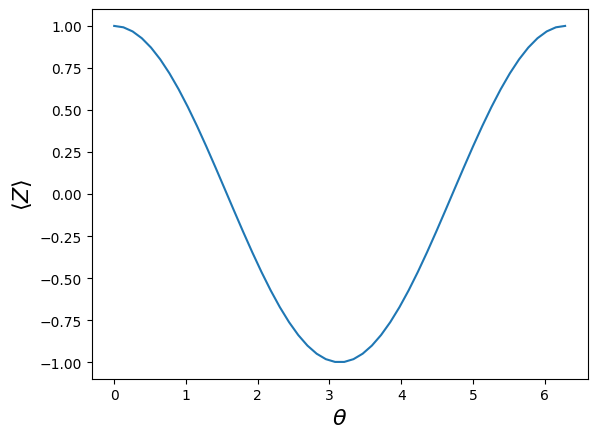

In [4]:
thetas = np.linspace(0, 2*np.pi, 50)
expvals = [circuit(theta) for theta in thetas]

plt.plot(thetas, expvals, '-')
plt.ylabel(r'$\langle Z \rangle$', fontsize=16)
plt.xlabel(r'$\theta$', fontsize=16)
plt.show()

### Classical minimzation of the expectation value
Let us now we create a classical-quantum loop that uses gradient descent to minimize the expectation value.

We add the `log_metric` function from Braket to record the training progress (see [metrics
documentation](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.jobs.metrics.html)).
The function logs a metric you choose to the console in a special format. When running on AWS, the logged metrics are published in [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/), and are accessible through the Braket console page or the Braket SDK.



In [5]:
def qubit_rotation(device, num_steps, stepsize):

    @qml.qnode(device)
    def circuit(params):
        qml.RX(params, wires=0)
        return qml.expval(qml.PauliZ(0))

    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    params = np.array([0.01])

    for i in range(num_steps):
        params = opt.step(circuit, params)
        expval = circuit(params)

        log_metric(metric_name="theta", iteration_number=i, value=float(params[0]))
        log_metric(metric_name="expval", iteration_number=i, value=expval)

    return params.tolist()[0]

### Verify the algorithm in our local environment

We can run this locally without using Amazon Braket.

In [6]:
device = qml.device("default.qubit", wires=1, shots=None)
optimal_theta = qubit_rotation(device, 25, stepsize=0.5)

print('\n', 'Optimized value of theta =', optimal_theta)

Metrics - timestamp=1723729768.2470536; theta=0.014999916667083332; iteration_number=0;
Metrics - timestamp=1723729768.2474556; expval=[0.9998875]; iteration_number=0;
Metrics - timestamp=1723729768.2534478; theta=0.022499593758476405; iteration_number=1;
Metrics - timestamp=1723729768.2534852; expval=[0.99974689]; iteration_number=1;
Metrics - timestamp=1723729768.2584262; theta=0.033748441494403265; iteration_number=2;
Metrics - timestamp=1723729768.258464; expval=[0.99943058]; iteration_number=2;
Metrics - timestamp=1723729768.263441; theta=0.05061945925452069; iteration_number=3;
Metrics - timestamp=1723729768.26349; expval=[0.99871911]; iteration_number=3;
Metrics - timestamp=1723729768.2685635; theta=0.07591838162133056; iteration_number=4;
Metrics - timestamp=1723729768.2686117; expval=[0.99711958]; iteration_number=4;
Metrics - timestamp=1723729768.2735398; theta=0.11384111933571739; iteration_number=5;
Metrics - timestamp=1723729768.2735796; expval=[0.99352709]; iteration_numb

Great! We see the expectation value change with each iteration number and the final parameter was returned. Now, instead of running on our laptop, let’s submit this same function to be run on AWS using Hybrid Jobs.

## Creating a Hybrid Job

<div align="center">
<img src="hybrid_job.png" width="900"/>
</div>

To run the algorithm defined above as a Hybrid Job, we only have to create a wrapper function which will run in the job container and prepares the inputs to the function `qubit_rotation` and stores its output.

Hyperparameters can be specified as function arguments and we simply annotate the function with the [`@hybrid_job` decorator](https://aws.amazon.com/blogs/quantum-computing/explore-quantum-algorithms-faster-by-running-your-local-python-code-as-an-amazon-braket-hybrid-job-with-minimal-code-changes/) where we can specify on which device we want to execute the quantum tasks.

Then, we create a hybrid job simply by invoking the wrapper function. 

#### Submit to on-demand simulator

Select the SV1 on-demand simulator to submit the job to. 

In [7]:
@hybrid_job(device=Devices.Amazon.SV1)
def qubit_rotation_sv1_job(num_steps=25, stepsize=0.5, shots=None):
    cost_tracker = Tracker().start()

    device = qml.device("braket.aws.qubit", device_arn=get_job_device_arn(), wires=1, shots=shots)
    theta = qubit_rotation(device, num_steps=num_steps, stepsize=stepsize)

    cost_tracker.stop()

    return {
        "theta": theta,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }


job_sv1 = qubit_rotation_sv1_job()

print(job_sv1.arn, job_sv1.state())

arn:aws:braket:us-east-1:977230113265:job/5d51c07b-7c85-431a-8ddc-ad5f672c0b70 QUEUED


In [11]:
print(job_sv1.state())

COMPLETED


#### Visualization on the Bloch sphere

In [16]:
animation = bloch_sphere_animation()

HTML(animation.to_jshtml())

<Figure size 500x500 with 0 Axes>

#### Let's plot the metrics

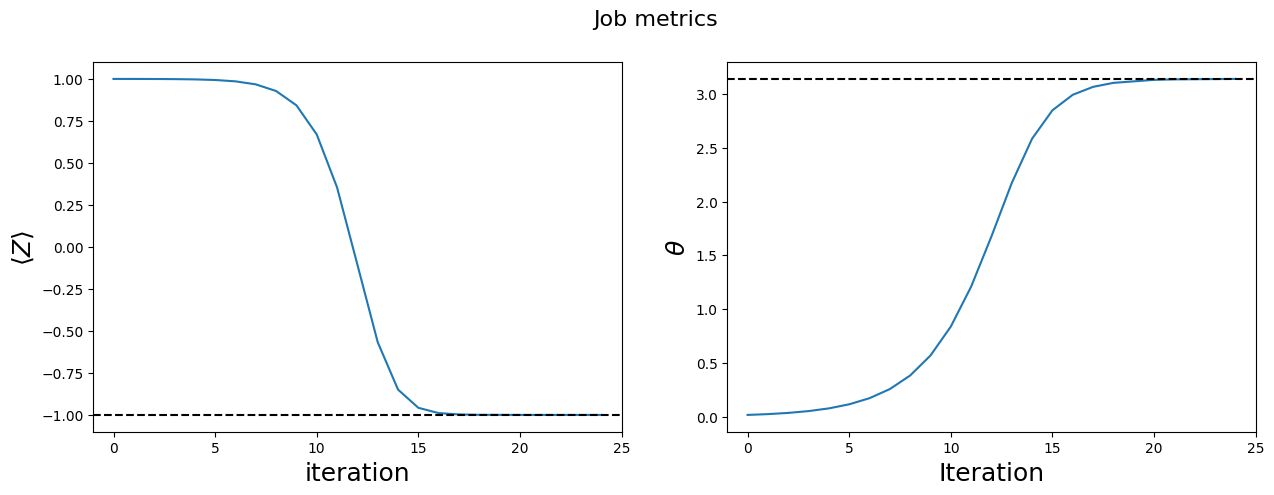

In [12]:
plot_job_metrics(job_sv1)

## Retrieve the job result

Once completed, the result can be retrieved using `job.result()`. Logs and metadata are also accessible via `job.logs()` and `job.metadata()`. If you lose the reference to the job object, you can always reinstantiate it using your job ARN as `job=AwsQuantumJob("your-job-arn")`. The ARN of a job can be found in the Amazon Braket Console. By default the ARN of a job will be "`arn:aws:braket:<region>:<account_id>:job/<job_name>`". 

In [14]:
job = AwsQuantumJob(job_sv1.arn)
job.state()

'COMPLETED'

In [15]:
result = job.result()
print(f"Create: {job.metadata()['createdAt']}")
print(f"Started: {job.metadata()['startedAt']}")
print(f"Ended: {job.metadata()['endedAt']}")
print()
print(f"Task summary: {job.result()['task summary']}")
print()
print(f"Runtime of the job instance: {job.metadata()['billableDuration']} milliseconds")
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")
print()
print(f"Optimized value of theta: {job.result()['theta']}")

Create: 2024-08-15 13:50:07.477000+00:00
Started: 2024-08-15 13:50:51.954000+00:00
Ended: 2024-08-15 13:54:21.534000+00:00

Task summary: {'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 50}, 'execution_duration': datetime.timedelta(microseconds=909000), 'billed_execution_duration': datetime.timedelta(seconds=150)}}

Runtime of the job instance: 210000 milliseconds
Estimated cost to run tasks in this job: 0.1875 USD

Optimized value of theta: 3.141011129989515


Note: Charges shown are estimates based on the Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

## Running jobs with priority on QPUs

With Braket Jobs, you can run hybrid algorithms on all QPUs available through Amazon Braket. When you select a QPU as your device, your job will have priority access for the duration of your job. Quantum tasks created as part of your job will be executed ahead of other tasks in the device queue. This reduces the risk of certain tasks being delayed or drifting calibrations on the device. 

Before you create a hybrid job which runs tasks on a QPU, you can check how many quantum tasks or hybrid jobs are in front of you by checking device queue depth.


When you create the job, Amazon Braket will wait for the QPU to become available before initializing the job. Note that the Braket Job will automatically select the AWS region where the device is available.

In [20]:
device = AwsDevice(Devices.IQM.Garnet)
print(device.queue_depth())

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0 (1 prioritized hybrid job running)')


* Normal task queue depth refers to the total number of quantum tasks currently waiting to run in normal priority.
* Priority task queue depth refers to the total number of submitted quantum tasks waiting to run through Amazon Braket Hybrid Jobs. These tasks run before standalone tasks.
* Hybrid jobs queue depth refers to the total number of hybrid jobs currently queued on a device. Quantum tasks submitted as part of a hybrid job have priority, and are aggregated in the Priority Task Queue.


After you have created a hybrid job, you can track its current position within a respective device queue.

Now let's create a Hybrid Job to submit to a QPU. This is exactly same as creating a job to submit to `SV1` simulator. All we need to do is provide the `arn` of the QPU to which we want to submit the job.

In [21]:
@hybrid_job(device=Devices.IQM.Garnet)
def qubit_rotation_qpu_job(num_steps=20, stepsize=0.5, shots=1000):
    cost_tracker = Tracker().start()

    device = qml.device("braket.aws.qubit", device_arn=get_job_device_arn(), wires=1, shots=shots)
    theta = qubit_rotation(device, num_steps=num_steps, stepsize=stepsize)

    cost_tracker.stop()
    return {
        "theta": theta,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }

We have already created the job at the beginning of this demo. The variable assigned to the QPU job object is `job_iqm`.

In [22]:
print(job_iqm.arn, job_iqm.state())

NameError: name 'job_iqm' is not defined

In [23]:
job_iqm.queue_position()

NameError: name 'job_iqm' is not defined

### Retrieve a previously executed job

In [ ]:
job_iqm = AwsQuantumJob('')

Retrieve results from completed job:

In [ ]:
print(f"Optimized theta = {job_iqm.result()['theta']}")

In [ ]:
plot_job_metrics(job_iqm)

In [ ]:
print(f"Create: {job_iqm.metadata()['createdAt']}")
print(f"Started: {job_iqm.metadata()['startedAt']}")
print(f"Ended: {job_iqm.metadata()['endedAt']}")
print()
print(f"Task summary: {job_iqm.result()['task summary']}")
print()
print(f"Runtime of the job instance: {job_iqm.metadata()['billableDuration']} milliseconds")
print(f"Estimated cost to run tasks in this job: {job_iqm.result()['estimated cost']} USD")
print()
print(f"Optimized value of theta: {job_iqm.result()['theta']}")

## Where to go from here

More example notebooks on Hybrid Jobs and on working with PennyLane on Braket are available in the current notebook environment under `./Braket examples/hybrid_jobs` and on the [Amazon Braket Examples](https://github.com/amazon-braket/amazon-braket-examples) repository on GitHub:
1. [Working wih PennyLane](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/pennylane)
2. [Quantum Approximate Optimization Algorithm](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms/QAOA).
3. [Variational Quantum Eigensolver](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms/VQE_Chemistry).
4. [Hybrid Jobs features](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_jobs).